# Logistic Regression with TensorFlow

## Libraries

The libraries used to image load and processing are,

* `imageio`
* `OpenCV (cv2)`
* `Numpy`
* `matplotlib` to plot results in order to depurate things

Which will be used in the helper functions shown on a section below.


# Helper functions

In order to load the images from the annotations file `gt.txt` I needed a set of helper functions.
The doc-strings on the functions are self-explanatory, but in summary,

* `annotation_parser` : extracts information from an annotation word  
* `get_annotated_ROI` : gets the ROI for a given annotation  
* `create_data_set_from_annotations` : generates a shuffled data set reading from an annotations file  
* `split_data` : splits the data into two batches, for training and testing.  

In [1]:
import tensorflow as tf

# Set parameters
learning_rate = 0.005
training_iteration = 100
batch_size = 121#244 #122
display_step = 10
test_size = 0.2

input_image_shape = (32,32)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import cv2
import imageio
import numpy as np
from sklearn.utils import shuffle

def annotation_parser(annotation, sep=";"):
    """
    anotation_parser extracts information of the ROI for a single annotation
    
    Input
    -----
    - annotation(string): The annotation for a single image
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - filename(string): The name of the file corresponding to the annotation
    - left_column(int): Coordinates for left column of the ROI
    - top_row(int): Coordinates of the top row of the ROI
    - right_column(int): Coordinates of the left column of the ROI
    - bottom_row(int): Coordinates of the bottom row of the ROI
    - category(int): The numerical category the image in the ROI belongs to
    
    """
    filename, left_column, top_row, right_column, bottom_row, category = annotation.split(sep)
    return filename, int(left_column), int(top_row), int(right_column), int(bottom_row), int(category)    


def get_annotated_ROI(annotation, path="FullIJCNN2013", as_gray=True, sep=";"):
    """
    get_annotated_ROI returns the ROI(an array) provided an annotation (string)
    
    Input
    -----
    - annotation(string): The annotation for a single image
    - path(string): Path containing the image files
    - as_gray(bool): If the image is loaded as RGB or Grayscale
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - img(numpy.array): The ROI
    - category(int): The numerical category the image in the ROI belongs to
    """
    image_file, left_column, top_row, right_column, bottom_row, cat = annotation_parser(annotation, sep)
    image_file = os.path.join(path, image_file)
    img = imageio.imread(image_file, as_gray=as_gray)
    return img[top_row:top_row+(right_column-left_column),left_column:left_column+(bottom_row-top_row)].copy(), cat


def create_data_set_from_annotations(annotations_file, path="FullIJCNN2013", as_gray=True, target_shape = input_image_shape, sep=";"):
    """
    create_data_set_from_annotations Generates a shuffled dataset of ROIs (X) and their labels (y)
    provided an annotations_file corresponding to the german traffic sings dataset
    
    Input
    -----
    - annotation_file(string): The name of annotations file
    - path(string): Path containing the annotations file
    - as_gray(bool): If the image is loaded as RGB or Grayscale
    - target_shape(tuple): Tuple with the expected size of each of the output ROIs'
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - X(numpy.array): Array of ROIs, one for each index
    - y(numpy.array): Array of labels corresponding to each of the ROIs on X
    """
    X = list()
    y = list()
    the_file = os.path.join(path, annotations_file)
    with open(the_file, "r") as annf:
        for line in annf:
            img, cat = get_annotated_ROI(line, path, as_gray, sep)
            img = cv2.resize(img, target_shape)
            img = img.flatten() # To get flat arrays of the image
            X.append(img) 
            y.append(cat)
            
    X, y = np.array(X), np.array(y)
    X, y = shuffle(X, y)
    return X, y


def split_data(Xo, yo, test_size=test_size):
    """
    split_data splits the data set X, y in two sets train_data, test_data and, train_labels, test_labels
    where the amount of elements of the second set correspond to the `test_size`
    percent of the amount of X, y
    
    Input
    -----
    - X(numpy.array): Array of features
    - y(numpy.array): Array of labels
    - test_size(float): Percentage of split(defalt 0.2)
    
    Returns
    -------
    - train_data(numpy.array) features to train
    - test_data(numpy.array) features to test
    - train_labels(numpy.array) labels of train_data
    - test_labels(numpy.array) labels of test_data
    
    """
    data_size = len(Xo)
    X, y = shuffle(Xo, yo)
    if (len(y) == data_size and test_size*data_size <= data_size) and (test_size <= 1.0):
        train_sz = int((1-test_size)*data_size)
        test_sz = int(test_size*data_size)
        
        train_data = np.zeros((train_sz,) + X.shape[1:])
        train_labels = np.zeros(train_sz)
        test_data = np.zeros((test_sz,) + X.shape[1:])
        test_labels = np.zeros(test_sz)
        
        for e in range(train_sz):
            index = np.random.randint(data_size)
            train_data[e] = X[index]
            train_labels[e] = y[index]
            
        for e in range(test_sz):
            index = np.random.randint(data_size)
            test_data[e] = X[index]
            test_labels[e] = y[index]
            
        return train_data, test_data, train_labels, test_labels
    else:
        print("Size miss_match")
        return Xo, yo, Xo, yo


def generate_data_batch(batch_size, features, labels, unique_labels):
    features_qty = len(features)
        
    if batch_size <= features_qty:
        
        labels_mapping = dict()
        clases_qty = len(unique_labels)
        ft_shape = features[0].shape
        
        # Generate a dictionary with the mapping of each unique_labels
        for cls_idx in range(clases_qty):
            labels_mapping[unique_labels[cls_idx]] = cls_idx
            
        
        the_batch_features = np.zeros((batch_size,) + ft_shape)
        the_batch_labels = np.zeros((batch_size, clases_qty))
        
        for i in range(batch_size):
            index = np.random.randint(features_qty)
            
            the_batch_features[i] = features[index]
            
            the_label = np.zeros(clases_qty)
            the_label[labels_mapping[labels[index]]] = 1.0
            
            the_batch_labels[i] = the_label
            
            # Shuffe the array a bit
            the_batch_features, the_batch_labels = shuffle(the_batch_features, the_batch_labels)
        
        return the_batch_features, the_batch_labels, labels_mapping

    else:
        return features, labels, None

# Lets tests that the functions work

In [3]:
ft = np.array([1,2,3,4,5,6])
cls = np.array([2,3,6,23,11,4])
a, b, lm = generate_data_batch(2, ft, cls, np.array(list(set(cls))))
print(a,b,lm)

[0. 4.] [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]] {2: 0, 3: 1, 4: 2, 6: 3, 23: 5, 11: 4}


In [4]:
a.shape

(2,)

In [5]:
b.shape

(2, 6)

In [6]:
X, y = create_data_set_from_annotations("gt.txt")

unique_labels = np.array(list(set(y)))

In [7]:
X.shape

(1213, 1024)

In [8]:
data_shape = X[0].shape[0]
data_shape

1024

In [9]:
number_of_clases = len(set(y))
number_of_clases

43

In [10]:
def split_data(X, y, test_size=0.2):
    data_size = len(X)
    if len(y) == data_size and test_size*data_size <= data_size:
        train_sz = int((1-test_size)*data_size)
        test_sz = int(test_size*data_size)
        
        train_data = np.zeros((train_sz,) + X.shape[1:])
        train_labels = np.zeros(train_sz)
        test_data = np.zeros((test_sz,) + X.shape[1:])
        test_labels = np.zeros(test_sz)
        
        for e in range(train_sz):
            index = np.random.randint(data_size)
            train_data[e] = X[index]
            train_labels[e] = y[index]
            
        for e in range(test_sz):
            index = np.random.randint(data_size)
            test_data[e] = X[index]
            test_labels[e] = y[index]
            
        return train_data, test_data, train_labels, test_labels
    else:
        print("Size miss_match")
        return X, y, X, y

In [11]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

n_train_samples = len(X_train)

In [12]:
X_train.shape

(970, 1024)

In [13]:
y_train.shape

(970,)

In [14]:
X_test, y_test, _ = generate_data_batch(len(X_test), X_test, y_test, unique_labels)

In [15]:
X_test.shape

(242, 1024)

In [16]:
y_test.shape

(242, 43)

In [17]:
# TF graph input (the flattened images)
x = tf.placeholder(tf.float32, [None, data_shape])

In [18]:
# Create a model

# Set model weights
W = tf.Variable(tf.zeros([data_shape, number_of_clases]))
b = tf.Variable(tf.zeros([number_of_clases]))

# To implement cross_entropy, here we store the correct answers
y_ = tf.placeholder(tf.float32, [None, number_of_clases])

In [19]:
x.shape

TensorShape([Dimension(None), Dimension(1024)])

In [20]:
y_.shape

TensorShape([Dimension(None), Dimension(43)])

In [21]:
W.shape

TensorShape([Dimension(1024), Dimension(43)])

In [22]:
b.shape

TensorShape([Dimension(43)])

In [23]:
# Construct a linear y `y = x*W + b`
#y = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax
y = tf.matmul(x, W) + b # Softmax

# Numerically more stable softmax 
cost_function = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [24]:
y.shape

TensorShape([Dimension(None), Dimension(43)])

In [25]:
cost_function.shape

TensorShape([])

In [26]:
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [27]:
batch_xs, batch_ys, _ = generate_data_batch(5, X_train, y_train, unique_labels)

In [28]:
batch_xs.shape

(5, 1024)

In [29]:
batch_ys.shape

(5, 43)

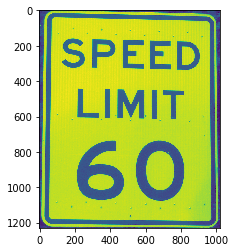

In [30]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

#taken from https://spettijohn.files.wordpress.com/2015/06/speed-limit-60.jpg
test_img = imageio.imread("speed-limit-60.jpg",as_gray=True)

plt.imshow(test_img[180:1410,550:1570])
plt.show()

In [31]:
tsing = test_img[180:1410,550:1570]
tsing.shape

(1230, 1020)

In [32]:
tsing = cv2.resize(tsing, input_image_shape)
tsing.shape

(32, 32)

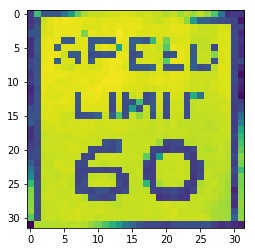

In [33]:
plt.imshow(tsing)
plt.show()

In [34]:
tsing = tsing.flatten()
tsing.shape

(1024,)

In [35]:
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    # Training loop
    for iteration in range(training_iteration):
        avg_result = 0.
        total_batch = int(n_train_samples/batch_size)
        #print("Iteration {}/{} with a total batch of {}".format(iteration, training_iteration, total_batch))
        for i in range(total_batch):
            batch_xs, batch_ys, labelings = generate_data_batch(batch_size, X_train, y_train, unique_labels)
            assert batch_xs.shape[0] == batch_ys.shape[0]

            
            sess.run(optimizer, feed_dict={x: batch_xs, y_: batch_ys})
            
            avg_result += sess.run(cost_function, feed_dict={x: batch_xs, y_: batch_ys})/total_batch
            #print("Accumulated cost{}",avg_cost)
        # Display logs per eiteration step
        if iteration % display_step == 0:
            print("Iteration:", '%04d' % (iteration + 1), "cost=", "{:.9f}".format(avg_result))
    
    print("Training complete!")
    
    print("Let's see the score:")
    #correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    correct_prediction = tf.equal(tf.argmax(y,0), tf.argmax(y_,0))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    error_ = sess.run(accuracy, feed_dict={x: X_test, y_: y_test})
    print("The measured error is {}".format(error_))
    print("The measured accuracy is {}".format(1-error_))
    
    classification = sess.run(y, feed_dict={x:[tsing]})
    print("The classification of test image was {}".format(classification))
    # Test the model
    #predictions = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    # Calculate accuracy
    #accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))
    #print("Accuracy:", accuracy.eval({x: X_test, y_: y_test}))

Iteration: 0001 cost= 4611.140167236
Iteration: 0011 cost= 959.125801086
Iteration: 0021 cost= 495.924866676
Iteration: 0031 cost= 36.116332531
Iteration: 0041 cost= 55.252310634
Iteration: 0051 cost= 34.750697672
Iteration: 0061 cost= 23.708188657
Iteration: 0071 cost= 22.900276721
Iteration: 0081 cost= 0.792744780
Iteration: 0091 cost= 0.595338558
Training complete!
Let's see the score:
The measured error is 0.1860465109348297
The measured accuracy is 0.8139534890651703
The classification of test image was [[-1346.6428    2472.8875   -2042.8157    -786.40607    -81.05525
   -197.06564   -597.49304   -436.48935  -1268.586    -2698.5093
  -1243.6361    -267.64685   3703.8948     844.08057   1215.8628
  -1323.3911    -348.56122   1375.3123     -14.211073   356.0759
   -157.16605    948.28033    191.90604    133.21556    826.042
   -837.07104     57.44279    487.08176    536.21344     19.474583
   -491.54047  -1080.7119     732.9885     -72.30217    486.1768
    449.86133    671.42596  -

In [36]:
cat_dict = {0 : " speed limit 20 (prohibitory)",
1 : " speed limit 30 (prohibitory)",
2 : " speed limit 50 (prohibitory)",
3 : " speed limit 60 (prohibitory)",
4 : " speed limit 70 (prohibitory)",
5 : " speed limit 80 (prohibitory)",
6 : " restriction ends 80 (other)",
7 : " speed limit 100 (prohibitory)",
8 : " speed limit 120 (prohibitory)",
9 : " no overtaking (prohibitory)",
10 : " no overtaking (trucks) (prohibitory)",
11 : " priority at next intersection (danger)",
12 : " priority road (other)",
13 : " give way (other)",
14 : " stop (other)",
15 : " no traffic both ways (prohibitory)",
16 : " no trucks (prohibitory)",
17 : " no entry (other)",
18 : " danger (danger)",
19 : " bend left (danger)",
20 : " bend right (danger)",
21 : " bend (danger)",
22 : " uneven road (danger)",
23 : " slippery road (danger)",
24 : " road narrows (danger)",
25 : " construction (danger)",
26 : " traffic signal (danger)",
27 : " pedestrian crossing (danger)",
28 : " school crossing (danger)",
29 : " cycles crossing (danger)",
30 : " snow (danger)",
31 : " animals (danger)",
32 : " restriction ends (other)",
33 : " go right (mandatory)",
34 : " go left (mandatory)",
35 : " go straight (mandatory)",
36 : " go right or straight (mandatory)",
37 : " go left or straight (mandatory)",
38 : " keep right (mandatory)",
39 : " keep left (mandatory)",
40 : " roundabout (mandatory)",
41 : " restriction ends (overtaking) (other)",
42 : " restriction ends (overtaking (trucks)) (other)"}

In [37]:
clfdict = {v:k for k,v in labelings.items()}
cat_dict[clfdict[np.argmax(classification)]]

' priority road (other)'

In [38]:
classification.shape

(1, 43)